In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import keras
from keras import layers
import os
import random
import plotly.graph_objects as go
import plotly.express as px

seed = 2727
os.environ['PYTHONHASHSEED']=str(seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


Heat Equation with Dirichlet boundary conditions on $[0,1]\times[-1,1]$:

\begin{align}
\partial_t u(t,x) - \partial^2_{xx}u(t,x) &= -e^{-t}(sin(\pi x) - \pi^2 sin(\pi x)) \\
u(0,x) &= sin(\pi x)\\
u(t,-1) &= u(t, 1) = 0
\end{align}

With exact solution

\begin{align}
u(t,x) = e^{-t} sin(\pi x)
\end{align}

Text(0.5, 0, 'z')

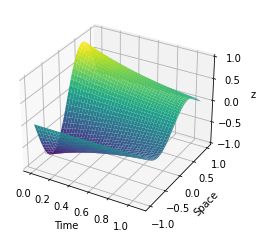

In [3]:
def true_solution(t, x):
    return np.exp(-t) * np.sin(x * np.pi)


T = np.arange(0, 1 + 0.1, 0.01)
X = np.arange(-1, 1, 0.01)

T, X = np.meshgrid(T, X)
Z = true_solution(T, X)



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(T, X, Z, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('z')

In [2]:
class Network:
    def __init__(self, layers_list: list) -> None:
        self.layers_list = layers_list

    def build(self):
        input_dim = self.layers_list.pop(0)
        ouput_dim = self.layers_list.pop()
        
        array = [layers.Input(shape=(input_dim,))]
        for units in self.layers_list:
            array.append(layers.Dense(units, activation="tanh", kernel_initializer="he_normal", bias_initializer="zeros"))
        array.append(layers.Dense(ouput_dim, kernel_initializer="he_normal", use_bias=False))
        
        nn = keras.Sequential(array)

        return nn

In [8]:
class HeatModel:
    # 1D Heat equation PINN-solver. It contains its own nn.
    def __init__(self):

        self.model = Network([2,50,50,50,50,50,50,1]).build()
    
    def init_condition(self, data):
        n = data.shape[0]
        return tf.reshape(tf.math.sin(data[...,1] * np.pi), shape=(n,1))
    
    ##################### LOSS METHODS ###########################

    def pde_loss(self, data):

        # Error given by the PDE over data.
        
        with tf.GradientTape() as tape2:
            tape2.watch(data)
            with tf.GradientTape() as tape1:
                tape1.watch(data)
                u = self.model(data)
            u_z = tape1.gradient(u, data)
        u_zz = tape2.gradient(u_z, data)
        
        u_t = u_z[..., 0]
        u_xx = u_zz[..., 1]
        #r = tf.math.exp(-data[..., 0]) * (tf.math.sin(data[..., 1] * np.pi) - (np.pi**2) * tf.math.sin(data[..., 1] * np.pi))
        #return tf.reduce_mean(tf.math.square(u_t - u_xx ))
        return u_t, u_xx

    def boundary_loss(self, data_init, data_left, data_right):
        l1 = tf.reduce_mean(tf.math.square(self.model(data_left)))
        l2 = tf.reduce_mean(tf.math.square(self.model(data_right)))
        l3 = tf.reduce_mean(tf.math.square(self.model(data_init) - self.init_condition(data_init)))
        return l1 + l2 + l3
    
    def total_loss(self, data_int, data_init, data_left, data_right):
        #+ self.pde_loss(data_int)
        #self.boundary_loss(data_init, data_left, data_right) +
        return self.pde_loss(data_int)
    ##################### TRAINING METHODS ###########################
    
    @tf.function
    def gradients(self, data_int, data_init, data_left, data_right):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            target = self.total_loss(data_int, data_init, data_left, data_right)
        return target, tape.gradient(target, self.model.trainable_variables)

    def fit_SGD(self, data_int, data_init, data_left, data_right):
        # Random mini-batch
        n = data_int.shape[0]
        l = []
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        b = 500
        for _ in tqdm(tf.range(1000)):
            i = np.random.randint(n - b)
            target, gradients = self.gradients(data_int[i:i+b], data_init[i:i+b], data_left[i:i+b], data_right[i:i+b])
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            l.append(target)
        return l
    
    def fit(self, data_int, data_init, data_left, data_right):
        l = []
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        for epoch in tqdm(tf.range(2000)):
            target, gradients = self.gradients(data_int, data_init, data_left, data_right)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            l.append(target)
        return l

In [9]:
model = HeatModel()

In [10]:
# batch_size
n = 5
# Interior data t \in [0,1], x \in [-1,1]
data_int = np.random.rand(n, 2)
data_int[..., 1] = data_int[..., 1]*2 - 1
data_int = tf.Variable(data_int, trainable=False, dtype="float32")
# t=0 data
data_init = np.random.rand(n,2) * 2 - 1
data_init[..., 0] = 0
data_init = tf.constant(data_init, dtype="float32")
# x = -1 data
data_left = np.random.rand(n,2) 
data_left[..., 1] = -1
data_left = tf.constant(data_left, dtype="float32")
# x = 1 data
data_right = np.random.rand(n,2) 
data_right[..., 1] = 1
data_right = tf.constant(data_right, dtype="float32")

In [13]:
tf.reshape(model.pde_loss(data_int)[0], shape=(5,1))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.09007317],
       [-1.7740338 ],
       [-0.49916965],
       [ 0.7665213 ],
       [-1.4382344 ]], dtype=float32)>

In [6]:
l = model.fit(data_int, data_init, data_left, data_right)


100%|██████████| 2000/2000 [00:26<00:00, 74.35it/s]


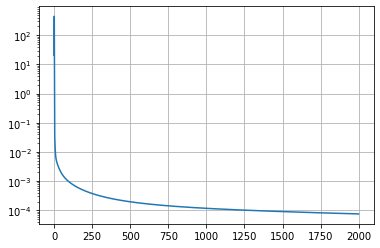

In [7]:
plt.plot(l)
plt.grid()
plt.yscale("log")